### 0/ Import

In [1]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocess, split and metric
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,plot_confusion_matrix,precision_recall_curve,roc_curve,make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# classifier algo
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import SVC

#random
np.random.seed(42)
import random
random.seed(42)

# Settings
import warnings
warnings.filterwarnings("ignore")
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load

In [2]:
# deep learning algo
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import backend
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Fixing the seed for random number generators
tf.random.set_seed(42)

# dask
from dask_ml.model_selection import GridSearchCV as DaskGridSearchCV

# keras tuner
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

#### Deep learning function

In [3]:
# Database to store result
df_accuracy = pd.DataFrame(columns=['Model name', 'Model arch.', 'Train Accuracy', 'Test_Accuracy', 'Time'])

In [4]:
def accuracy_vs_epochs(history, from_epoc=20):
    df = pd.DataFrame(history.history).iloc[from_epoc:]
    plt.figure(figsize = (4,2))
    plt.plot(df['accuracy'])
    plt.plot(df['val_accuracy'])
    plt.xlim(left=from_epoc-2)
    plt.title('Accuracy vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

In [5]:
# Creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(6,3))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [6]:
training_time=0
def dl_performance(name, model, threshold=0.5):
    y_hat_train = np.where(model.predict(X_train) > threshold,1,0)
    y_hat_test = np.where(model.predict(X_test) > threshold,1,0)
    
    # calculate accuracy
    accuracy_train = round(accuracy_score(y_train, y_hat_train),5)
    accuracy_test = round(accuracy_score(y_test, y_hat_test),5)
    
    # store result
    df_accuracy.loc[len(df_accuracy.index)] = [name, model, accuracy_train, accuracy_test, training_time]
    
    # print
    print(f'Model: {name}')
    print(f'Accuracy train: {accuracy_train}')
    print(f'Accuracy test: {accuracy_test}')

    metrics_score(y_test, y_hat_test)

In [7]:
# export submission
def export_submission(model_name, model, note_version):
    print('Exporting ',model_name,'...')
    y_hat = np.round(model.predict(df_submit))
    df_to_submit = pd.DataFrame()
    df_to_submit['ID'] = ID_col
    df_to_submit['Overall_Experience'] = y_hat
    filename = 'submission_model_' + model_name + '_fromfile_' + note_version + '.csv'
    df_to_submit.to_csv(filename, index = False)
    print('Finish ',filename)

In [8]:
# function to create copyable nn model from string input
def create_DL(model_name, learning_rate=0.001):
    model_input = input()
    model_parameters = model_input.split(' ')[1::2]
    num_of_layers = model_parameters[0]
    layer_parameters = model_parameters[1:]
    if model_input.split(' ')[14] == 'learning_rate:':
        learning_rate = layer_parameters[6]
        layer_parameters = layer_parameters[:6]+layer_parameters[7:]
        
    num_of_neurons = layer_parameters[0::3]
    activator = layer_parameters[1::3]
    dropout = layer_parameters[2::3]
        
    
    #print('-'*40)
    #print('MODEL COPYABLE PARAMETERS:\n')
    print(f'# MODEL {model_name}')
    print('backend.clear_session()')
    print(model_name,'= Sequential()\n')

    print('# Layer 1 (input layer)')
    print(model_name + '.add(Dense(' + num_of_neurons[0] + ',activation=\'' + activator[0] +'\',kernel_initializer=\'he_uniform\',input_dim = X_train.shape[1]))') 
    print(model_name + '.add(Dropout(' + dropout[0] + '))')

    for i in range(1,int(num_of_layers)):
        print('#Layer', i+1)
        print(model_name + '.add(Dense(' + num_of_neurons[i] + ',activation=\'' + activator[i] +'\',kernel_initializer=\'he_uniform\'))') 
        print(model_name + '.add(Dropout(' + dropout[i] + '))')

    # Output layer
    print('#Output layer')
    print(model_name + '.add(Dense(1, activation = \'sigmoid\'))')
    print(f'optimizer = tf.keras.optimizers.Adam({learning_rate})')
    print(model_name + '.compile(loss=\'binary_crossentropy\',optimizer=optimizer,metrics=[\'accuracy\'])')

    print(f'history = {model_name}.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.1)')
    print('accuracy_vs_epochs(history,20)')
    print(f'dl_performance(\'{model_name}\', {model_name})')

In [77]:
# function to create copyable nn model from string input
def create_DL_fixed_layer(model_name, layers, learning_rate=0.001):
    model_input = 'num_layers: ' + str(layers) + ' ' + input()
    model_parameters = model_input.split(' ')[1::2]
    num_of_layers = model_parameters[0]
    layer_parameters = model_parameters[1:]
    if model_input.split(' ')[14] == 'learning_rate:':
        learning_rate = layer_parameters[6]
        layer_parameters = layer_parameters[:6]+layer_parameters[7:]
        
    num_of_neurons = layer_parameters[0::3]
    activator = layer_parameters[1::3]
    dropout = layer_parameters[2::3]
        
    
    #print('-'*40)
    #print('MODEL COPYABLE PARAMETERS:\n')
    print(f'# MODEL {model_name}')
    print('backend.clear_session()')
    print(model_name,'= Sequential()\n')

    print('# Layer 1 (input layer)')
    print(model_name + '.add(Dense(' + num_of_neurons[0] + ',activation=\'' + activator[0] +'\',kernel_initializer=\'he_uniform\',input_dim = X_train.shape[1]))') 
    print(model_name + '.add(Dropout(' + dropout[0] + '))')

    for i in range(1,int(num_of_layers)):
        print('#Layer', i+1)
        print(model_name + '.add(Dense(' + num_of_neurons[i] + ',activation=\'' + activator[i] +'\',kernel_initializer=\'he_uniform\'))') 
        print(model_name + '.add(Dropout(' + dropout[i] + '))')

    # Output layer
    print('#Output layer')
    print(model_name + '.add(Dense(1, activation = \'sigmoid\'))')
    print(f'optimizer = tf.keras.optimizers.Adam({learning_rate})')
    print(model_name + '.compile(loss=\'binary_crossentropy\',optimizer=optimizer,metrics=[\'accuracy\'])')

    print(f'history = {model_name}.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.1)')
    print('accuracy_vs_epochs(history,20)')
    print(f'dl_performance(\'{model_name}\', {model_name})')

#### Data

In [9]:
df = pd.read_csv('2.0.2 df_imputed.csv')
df_submit = pd.read_csv("2.0.2 df_submit_imputed.csv")

### 1/ Prep

In [10]:
unnecessary_cols = ['ID']
df.drop(columns = unnecessary_cols, inplace=True)

ID_col = df_submit['ID']
df_submit.drop(columns = unnecessary_cols, inplace=True)

In [11]:
#Convert rating to numeric first
standard_rating = ['Seat_Comfort',
                   'Arrival_Time_Convenient',
                   'Catering',
                   'Onboard_Wifi_Service',
                   'Onboard_Entertainment',
                   'Online_Support',
                   'Ease_of_Online_Booking',
                   'Onboard_Service',
                   'Legroom',
                   'Baggage_Handling',
                   'CheckIn_Service',
                   'Cleanliness',
                   'Online_Boarding']

for col in standard_rating:
    df[col].replace(['Excellent', 'Good', 'Acceptable', 'Needs Improvement', 'Poor', 'Extremely Poor'],
                    [5, 4, 3, 2, 1, 0], inplace = True)
    df_submit[col].replace(['Excellent', 'Good', 'Acceptable', 'Needs Improvement', 'Poor', 'Extremely Poor'],
                    [5, 4, 3, 2, 1, 0], inplace = True)
df['Platform_Location'].replace(['Very Convenient', 'Convenient', 'Manageable', 'Needs Improvement', 'Inconvenient','Very Inconvenient'], 
                                [5,4,3,2,1,0], inplace = True)
df_submit['Platform_Location'].replace(['Very Convenient', 'Convenient', 'Manageable', 'Needs Improvement', 'Inconvenient','Very Inconvenient'], 
                                [5,4,3,2,1,0], inplace = True)
df.head(5)

,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,0,2,Green Car,5,5,5,4,2,3,2,2,3,2,4,2,1,Female,Loyal Customer,52.0,Business Travel,Business,272,0.0,5.0
1,0,1,Ordinary,5,1,2,4,1,4,4,5,2,1,2,4,4,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,1,2,Green Car,2,2,2,2,4,5,5,5,5,5,4,5,5,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0
3,0,3,Ordinary,2,3,2,3,2,3,3,3,3,3,4,3,3,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0
4,1,3,Ordinary,3,3,3,2,4,5,4,4,4,4,4,4,4,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0


In [12]:
# Creating list of dummy columns
to_get_dummies1 = ['Seat_Class','Customer_Type','Type_Travel','Gender', 'Travel_Class',]

# Creating dummy variables
df = pd.get_dummies(data = df, columns = to_get_dummies1, drop_first = True)  
df_submit = pd.get_dummies(data = df_submit, columns = to_get_dummies1, drop_first = True)  

#### Train data

In [13]:
Y = df['Overall_Experience']

In [14]:
X = df.drop(columns = ['Overall_Experience'])

X['Age'] = df['Age']/10
X['Travel_Distance'] = np.sqrt(df['Travel_Distance'])

X = X.values.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=14)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
input_features = X_train.shape[1]

#### Test data

In [16]:
df_submit['Age'] = df_submit['Age']/10
df_submit['Travel_Distance'] = np.sqrt(df_submit['Travel_Distance'])

#df_submit['DepartureDelay_in_Mins'][df_submit['DepartureDelay_in_Mins']>0] = np.log(df_submit['DepartureDelay_in_Mins'][df_submit['DepartureDelay_in_Mins']>0])
#df_submit['ArrivalDelay_in_Mins'][df_submit['ArrivalDelay_in_Mins']>0] = np.log(df_submit['ArrivalDelay_in_Mins'][df_submit['ArrivalDelay_in_Mins']>0])

df_submit = df_submit.values.astype(float)

df_submit = scaler.transform(df_submit)

### 2/ Base model DL_1

In [16]:
backend.clear_session()
DL_1 = Sequential()
DL_1.add(Dense(128, activation='relu', input_shape=(input_features,)))
DL_1.add(Dropout(0.2))
DL_1.add(Dense(64, activation='relu'))
DL_1.add(Dropout(0.1))
DL_1.add(Dense(1, activation='sigmoid'))
DL_1.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
DL_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3072      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,393
Trainable params: 11,393
Non-trainable params: 0
_________________________________________________________________


In [17]:
start = time.time()
history = DL_1.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=1)
training_time = round(time.time() - start,2)

Epoch 1/100
2124/2124 [==============================] - 4s 1ms/step - loss: 0.2552 - accuracy: 0.8915 - val_loss: 0.1940 - val_accuracy: 0.9143
Epoch 2/100
2124/2124 [==============================] - 3s 1ms/step - loss: 0.1906 - accuracy: 0.9192 - val_loss: 0.1621 - val_accuracy: 0.9246
Epoch 3/100
2124/2124 [==============================] - 3s 1ms/step - loss: 0.1655 - accuracy: 0.9291 - val_loss: 0.1421 - val_accuracy: 0.9355
Epoch 4/100
2124/2124 [==============================] - 3s 1ms/step - loss: 0.1486 - accuracy: 0.9355 - val_loss: 0.1341 - val_accuracy: 0.9395
Epoch 5/100
2124/2124 [==============================] - 3s 2ms/step - loss: 0.1407 - accuracy: 0.9399 - val_loss: 0.1265 - val_accuracy: 0.9435
Epoch 6/100
2124/2124 [==============================] - 3s 2ms/step - loss: 0.1331 - accuracy: 0.9422 - val_loss: 0.1281 - val_accuracy: 0.9452
Epoch 7/100
2124/2124 [==============================] - 3s 1ms/step - loss: 0.1284 - accuracy: 0.9448 - val_loss: 0.1190 - val_ac

590/590 [==============================] - 0s 803us/step
Model name                                                     DL_1
Model arch.       <keras.engine.sequential.Sequential object at ...
Train Accuracy                                              0.97154
Test_Accuracy                                               0.95582
Time                                                          308.0
Name: 0, dtype: object


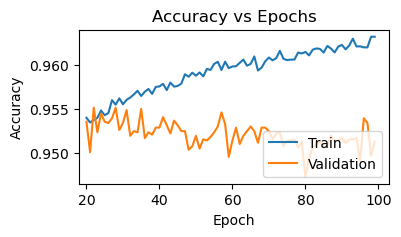

In [18]:
print(dl_performance('DL_1', DL_1))
accuracy_vs_epochs(history,20)

In [19]:
backend.clear_session()


### 3/ 3 layer

In [17]:
backend.clear_session()

Adjust the tuning function in a way that starts with large neuron depending on the number of layers and decrease subsequently.

In [ ]:
# debug
# no_of_layers = 4
# neurons_per_layer = [32,32,64,128,196,256,256,256,320,320,320,320]

# for i in range(no_of_layers):
#     print(str(i), neurons_per_layer[(no_of_layers-i):(no_of_layers-i+3)])

In [75]:
def build_model(h):
    model = keras.Sequential()
    # Number of layer: min - max
    no_of_layers = 3 # h.Int('num_layers', 2, 8)
    neurons_per_layer = [32,32,64,128,196,256,256,256,320,320,320,320]

    for i in range(no_of_layers):
        model.add(layers.Dense(
            units=h.Choice('units_' + str(i), neurons_per_layer[(no_of_layers-i):(no_of_layers-i+3)]),
            # Activation function for each layer
            activation= h.Choice('act_' + str(i), ['relu','sigmoid'])))
        # Tune with dropout or not
        model.add(Dropout(h.Choice('dropout_'+ str(i), [0.0, 0.1,0.2,0.5])))
    # output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    # compiler
    model.compile(
        # Adjust learning rate
        optimizer=keras.optimizers.Adam(h.Choice('learning_rate', [1e-2, 1e-3])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [76]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=7,  #defaul 5-7
    executions_per_trial=3, #defaul 3-5
    project_name='Job',
    overwrite=True)
#tuner.search_space_summary()
start = time.time()
tuner.search(X_train, y_train, epochs=8, # default about 5-10
             validation_data = (X_test,y_test))
print('Tuning completed in: ', round(time.time()-start,2),'s')
tuner.results_summary()

Trial 7 Complete [00h 01m 42s]
val_accuracy: 0.9450801610946655

Best val_accuracy So Far: 0.951543390750885
Total elapsed time: 00h 12m 22s
INFO:tensorflow:Oracle triggered exit
Tuning completed in:  741.84 s
Results summary
Results in .\Job
Showing 10 best trials
Trial summary
Hyperparameters:
units_0: 128
act_0: relu
dropout_0: 0.2
units_1: 64
act_1: relu
dropout_1: 0.0
units_2: 64
act_2: relu
dropout_2: 0.1
learning_rate: 0.001
Score: 0.951543390750885
Trial summary
Hyperparameters:
units_0: 196
act_0: relu
dropout_0: 0.5
units_1: 196
act_1: sigmoid
dropout_1: 0.0
units_2: 128
act_2: relu
dropout_2: 0.1
learning_rate: 0.001
Score: 0.9493007063865662
Trial summary
Hyperparameters:
units_0: 196
act_0: relu
dropout_0: 0.5
units_1: 128
act_1: sigmoid
dropout_1: 0.0
units_2: 128
act_2: relu
dropout_2: 0.0
learning_rate: 0.001
Score: 0.9491241176923116
Trial summary
Hyperparameters:
units_0: 196
act_0: relu
dropout_0: 0.5
units_1: 128
act_1: sigmoid
dropout_1: 0.1
units_2: 128
act_2: sig

#### Build model with above parameter

##### Model DL_tune1

In [78]:
create_DL_fixed_layer('DL_tune1', 3)

 units_0: 128 act_0: relu dropout_0: 0.2 units_1: 64 act_1: relu dropout_1: 0.0 units_2: 64 act_2: relu dropout_2: 0.1 learning_rate: 0.001


# MODEL DL_tune1
backend.clear_session()
DL_tune1 = Sequential()

# Layer 1 (input layer)
DL_tune1.add(Dense(128,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
DL_tune1.add(Dropout(0.2))
#Layer 2
DL_tune1.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
DL_tune1.add(Dropout(0.0))
#Layer 3
DL_tune1.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
DL_tune1.add(Dropout(0.1))
#Output layer
DL_tune1.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.001)
DL_tune1.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = DL_tune1.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.1)
accuracy_vs_epochs(history,20)
dl_performance('DL_tune1', DL_tune1)


Epoch 1/50
1062/1062 [==============================] - 2s 2ms/step - loss: 0.2872 - accuracy: 0.8759 - val_loss: 0.2045 - val_accuracy: 0.9109
Epoch 2/50
1062/1062 [==============================] - 2s 2ms/step - loss: 0.2114 - accuracy: 0.9105 - val_loss: 0.1767 - val_accuracy: 0.9192
Epoch 3/50
1062/1062 [==============================] - 2s 2ms/step - loss: 0.1882 - accuracy: 0.9199 - val_loss: 0.1606 - val_accuracy: 0.9297
Epoch 4/50
1062/1062 [==============================] - 2s 2ms/step - loss: 0.1720 - accuracy: 0.9263 - val_loss: 0.1506 - val_accuracy: 0.9329
Epoch 5/50
1062/1062 [==============================] - 2s 2ms/step - loss: 0.1606 - accuracy: 0.9313 - val_loss: 0.1474 - val_accuracy: 0.9350
Epoch 6/50
1062/1062 [==============================] - 2s 2ms/step - loss: 0.1545 - accuracy: 0.9339 - val_loss: 0.1419 - val_accuracy: 0.9372
Epoch 7/50
1062/1062 [==============================] - 2s 2ms/step - loss: 0.1475 - accuracy: 0.9365 - val_loss: 0.1369 - val_accuracy:

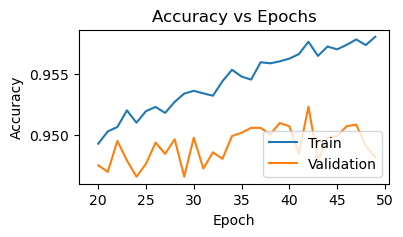

590/590 [==============================] - 0s 760us/step
Model: DL_tune1
Accuracy train: 0.96556
Accuracy test: 0.95264
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      8576
           1       0.96      0.95      0.96     10300

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876



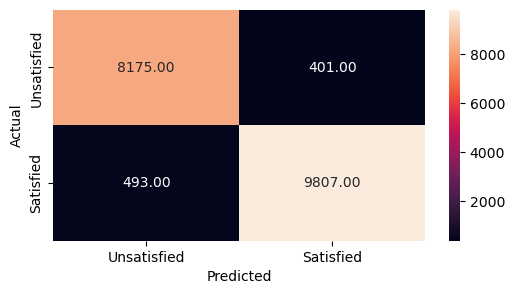

In [79]:
# MODEL DL_tune1
backend.clear_session()
DL_tune1 = Sequential()

# Layer 1 (input layer)
DL_tune1.add(Dense(128,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
DL_tune1.add(Dropout(0.2))
#Layer 2
DL_tune1.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
DL_tune1.add(Dropout(0.0))
#Layer 3
DL_tune1.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
DL_tune1.add(Dropout(0.1))
#Output layer
DL_tune1.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.001)
DL_tune1.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = DL_tune1.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.1)
accuracy_vs_epochs(history,20)
dl_performance('DL_tune1', DL_tune1)

### 4/ 4 layers

In [80]:
backend.clear_session()

In [81]:
def build_model(h):
    model = keras.Sequential()
    # Number of layer: min - max
    no_of_layers = 4 # h.Int('num_layers', 2, 8)
    neurons_per_layer = [32,32,64,128,196,256,256,256,320,320,320,320]

    for i in range(no_of_layers):
        model.add(layers.Dense(
            units=h.Choice('units_' + str(i), neurons_per_layer[(no_of_layers-i):(no_of_layers-i+3)]),
            # Activation function for each layer
            activation= h.Choice('act_' + str(i), ['relu','sigmoid'])))
        # Tune with dropout or not
        model.add(Dropout(h.Choice('dropout_'+ str(i), [0.0, 0.1,0.2,0.5])))
    # output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    # compiler
    model.compile(
        # Adjust learning rate
        optimizer=keras.optimizers.Adam(h.Choice('learning_rate', [1e-2, 1e-3])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [82]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  #defaul 5-7
    executions_per_trial=3, #defaul 3-5
    project_name='Job',
    overwrite=True)
#tuner.search_space_summary()
start = time.time()
tuner.search(X_train, y_train, epochs=8, # default about 5-10
             validation_data = (X_test,y_test))
print('Tuning completed in: ', round(time.time()-start,2),'s')
tuner.results_summary()

Trial 5 Complete [00h 02m 15s]
val_accuracy: 0.9423960049947103

Best val_accuracy So Far: 0.9513314962387085
Total elapsed time: 00h 10m 57s
INFO:tensorflow:Oracle triggered exit
Tuning completed in:  657.45 s
Results summary
Results in .\Job
Showing 10 best trials
Trial summary
Hyperparameters:
units_0: 196
act_0: relu
dropout_0: 0.2
units_1: 128
act_1: relu
dropout_1: 0.1
units_2: 64
act_2: relu
dropout_2: 0.5
units_3: 64
act_3: relu
dropout_3: 0.1
learning_rate: 0.001
Score: 0.9513314962387085
Trial summary
Hyperparameters:
units_0: 256
act_0: relu
dropout_0: 0.5
units_1: 256
act_1: sigmoid
dropout_1: 0.5
units_2: 196
act_2: sigmoid
dropout_2: 0.1
units_3: 64
act_3: sigmoid
dropout_3: 0.2
learning_rate: 0.001
Score: 0.9461926817893982
Trial summary
Hyperparameters:
units_0: 256
act_0: sigmoid
dropout_0: 0.2
units_1: 128
act_1: sigmoid
dropout_1: 0.1
units_2: 196
act_2: relu
dropout_2: 0.1
units_3: 64
act_3: relu
dropout_3: 0.5
learning_rate: 0.01
Score: 0.9423960049947103
Trial sum

#### Build model with above parameter

In [92]:
create_DL_fixed_layer('DL_tune2', 4)

 units_0: 196 act_0: relu dropout_0: 0.2 units_1: 128 act_1: relu dropout_1: 0.1 units_2: 64 act_2: relu dropout_2: 0.5 units_3: 64 act_3: relu dropout_3: 0.1 learning_rate: 0.001


# MODEL DL_tune2
backend.clear_session()
DL_tune2 = Sequential()

# Layer 1 (input layer)
DL_tune2.add(Dense(196,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
DL_tune2.add(Dropout(0.2))
#Layer 2
DL_tune2.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
DL_tune2.add(Dropout(0.1))
#Layer 3
DL_tune2.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
DL_tune2.add(Dropout(0.5))
#Layer 4
DL_tune2.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
DL_tune2.add(Dropout(0.1))
#Output layer
DL_tune2.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.001)
DL_tune2.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = DL_tune2.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.1)
accuracy_vs_epochs(history,20)
dl_performance('DL_tune2', DL_tune2)


Epoch 1/50
1062/1062 [==============================] - 3s 3ms/step - loss: 0.3217 - accuracy: 0.8626 - val_loss: 0.2149 - val_accuracy: 0.9068
Epoch 2/50
1062/1062 [==============================] - 3s 2ms/step - loss: 0.2234 - accuracy: 0.9080 - val_loss: 0.1823 - val_accuracy: 0.9188
Epoch 3/50
1062/1062 [==============================] - 3s 2ms/step - loss: 0.1946 - accuracy: 0.9174 - val_loss: 0.1678 - val_accuracy: 0.9269
Epoch 4/50
1062/1062 [==============================] - 3s 2ms/step - loss: 0.1792 - accuracy: 0.9237 - val_loss: 0.1601 - val_accuracy: 0.9310
Epoch 5/50
1062/1062 [==============================] - 3s 2ms/step - loss: 0.1678 - accuracy: 0.9288 - val_loss: 0.1489 - val_accuracy: 0.9344
Epoch 6/50
1062/1062 [==============================] - 3s 2ms/step - loss: 0.1581 - accuracy: 0.9324 - val_loss: 0.1440 - val_accuracy: 0.9374
Epoch 7/50
1062/1062 [==============================] - 3s 2ms/step - loss: 0.1509 - accuracy: 0.9362 - val_loss: 0.1418 - val_accuracy:

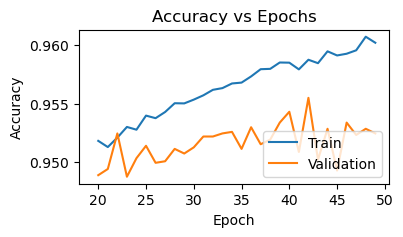

590/590 [==============================] - 0s 803us/step
Model: DL_tune2
Accuracy train: 0.9667
Accuracy test: 0.95327
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      8576
           1       0.97      0.94      0.96     10300

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876



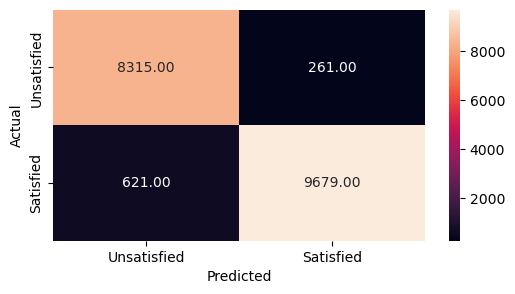

In [96]:
# MODEL DL_tune2
backend.clear_session()
DL_tune2 = Sequential()

# Layer 1 (input layer)
DL_tune2.add(Dense(196,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
DL_tune2.add(Dropout(0.2))
#Layer 2
DL_tune2.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
DL_tune2.add(Dropout(0.1))
#Layer 3
DL_tune2.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
DL_tune2.add(Dropout(0.5))
#Layer 4
DL_tune2.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
DL_tune2.add(Dropout(0.1))
#Output layer
DL_tune2.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.001)
DL_tune2.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = DL_tune2.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.1)
accuracy_vs_epochs(history,20)
dl_performance('DL_tune2', DL_tune2)

### 5/ 5 layers

In [83]:
backend.clear_session()

In [84]:
def build_model(h):
    model = keras.Sequential()
    # Number of layer: min - max
    no_of_layers = 5 # h.Int('num_layers', 2, 8)
    neurons_per_layer = [32,32,64,128,196,256,256,256,320,320,320,320]

    for i in range(no_of_layers):
        model.add(layers.Dense(
            units=h.Choice('units_' + str(i), neurons_per_layer[(no_of_layers-i):(no_of_layers-i+3)]),
            # Activation function for each layer
            activation= h.Choice('act_' + str(i), ['relu','sigmoid'])))
        # Tune with dropout or not
        model.add(Dropout(h.Choice('dropout_'+ str(i), [0.0, 0.1,0.2,0.5])))
    # output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    # compiler
    model.compile(
        # Adjust learning rate
        optimizer=keras.optimizers.Adam(h.Choice('learning_rate', [1e-2, 1e-3])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [85]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  #defaul 5-7
    executions_per_trial=3, #defaul 3-5
    project_name='Job',
    overwrite=True)
#tuner.search_space_summary()
start = time.time()
tuner.search(X_train, y_train, epochs=8, # default about 5-10
             validation_data = (X_test,y_test))
print('Tuning completed in: ', round(time.time()-start,2),'s')
tuner.results_summary()

Trial 5 Complete [00h 02m 31s]
val_accuracy: 0.9340432484944662

Best val_accuracy So Far: 0.952090859413147
Total elapsed time: 00h 12m 12s
INFO:tensorflow:Oracle triggered exit
Tuning completed in:  731.83 s
Results summary
Results in .\Job
Showing 10 best trials
Trial summary
Hyperparameters:
units_0: 256
act_0: relu
dropout_0: 0.1
units_1: 256
act_1: sigmoid
dropout_1: 0.2
units_2: 196
act_2: relu
dropout_2: 0.0
units_3: 196
act_3: sigmoid
dropout_3: 0.1
units_4: 128
act_4: sigmoid
dropout_4: 0.1
learning_rate: 0.001
Score: 0.952090859413147
Trial summary
Hyperparameters:
units_0: 256
act_0: relu
dropout_0: 0.5
units_1: 196
act_1: sigmoid
dropout_1: 0.0
units_2: 128
act_2: sigmoid
dropout_2: 0.0
units_3: 196
act_3: relu
dropout_3: 0.1
units_4: 128
act_4: relu
dropout_4: 0.0
learning_rate: 0.001
Score: 0.9495302637418112
Trial summary
Hyperparameters:
units_0: 256
act_0: sigmoid
dropout_0: 0.1
units_1: 256
act_1: relu
dropout_1: 0.2
units_2: 196
act_2: sigmoid
dropout_2: 0.1
units_3

#### Build model with above parameter

In [93]:
create_DL_fixed_layer('DL_tune3', 5)

 units_0: 256 act_0: relu dropout_0: 0.1 units_1: 256 act_1: sigmoid dropout_1: 0.2 units_2: 196 act_2: relu dropout_2: 0.0 units_3: 196 act_3: sigmoid dropout_3: 0.1 units_4: 128 act_4: sigmoid dropout_4: 0.1 learning_rate: 0.001


# MODEL DL_tune3
backend.clear_session()
DL_tune3 = Sequential()

# Layer 1 (input layer)
DL_tune3.add(Dense(256,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
DL_tune3.add(Dropout(0.1))
#Layer 2
DL_tune3.add(Dense(256,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune3.add(Dropout(0.2))
#Layer 3
DL_tune3.add(Dense(196,activation='relu',kernel_initializer='he_uniform'))
DL_tune3.add(Dropout(0.0))
#Layer 4
DL_tune3.add(Dense(196,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune3.add(Dropout(0.1))
#Layer 5
DL_tune3.add(Dense(128,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune3.add(Dropout(0.1))
#Output layer
DL_tune3.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.001)
DL_tune3.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = DL_tune3.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.1)
accuracy_vs_epochs(history,20)
dl_perf

Epoch 1/50
1062/1062 [==============================] - 4s 3ms/step - loss: 0.2607 - accuracy: 0.8895 - val_loss: 0.1957 - val_accuracy: 0.9135
Epoch 2/50
1062/1062 [==============================] - 3s 3ms/step - loss: 0.1851 - accuracy: 0.9214 - val_loss: 0.1632 - val_accuracy: 0.9278
Epoch 3/50
1062/1062 [==============================] - 3s 3ms/step - loss: 0.1627 - accuracy: 0.9300 - val_loss: 0.1412 - val_accuracy: 0.9370
Epoch 4/50
1062/1062 [==============================] - 3s 3ms/step - loss: 0.1456 - accuracy: 0.9365 - val_loss: 0.1431 - val_accuracy: 0.9389
Epoch 5/50
1062/1062 [==============================] - 3s 3ms/step - loss: 0.1369 - accuracy: 0.9402 - val_loss: 0.1326 - val_accuracy: 0.9438
Epoch 6/50
1062/1062 [==============================] - 3s 3ms/step - loss: 0.1301 - accuracy: 0.9433 - val_loss: 0.1284 - val_accuracy: 0.9413
Epoch 7/50
1062/1062 [==============================] - 3s 3ms/step - loss: 0.1238 - accuracy: 0.9459 - val_loss: 0.1238 - val_accuracy:

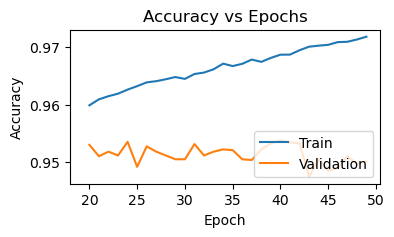

590/590 [==============================] - 1s 897us/step
Model: DL_tune3
Accuracy train: 0.97873
Accuracy test: 0.95364
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8576
           1       0.96      0.96      0.96     10300

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876



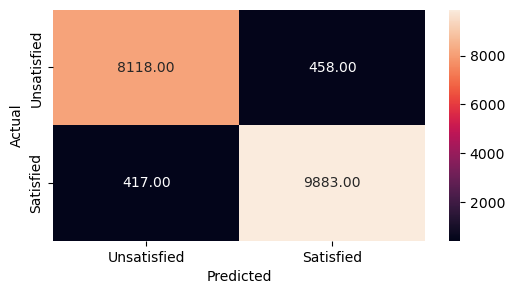

In [97]:
# MODEL DL_tune3
backend.clear_session()
DL_tune3 = Sequential()

# Layer 1 (input layer)
DL_tune3.add(Dense(256,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
DL_tune3.add(Dropout(0.1))
#Layer 2
DL_tune3.add(Dense(256,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune3.add(Dropout(0.2))
#Layer 3
DL_tune3.add(Dense(196,activation='relu',kernel_initializer='he_uniform'))
DL_tune3.add(Dropout(0.0))
#Layer 4
DL_tune3.add(Dense(196,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune3.add(Dropout(0.1))
#Layer 5
DL_tune3.add(Dense(128,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune3.add(Dropout(0.1))
#Output layer
DL_tune3.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.001)
DL_tune3.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = DL_tune3.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.1)
accuracy_vs_epochs(history,20)
dl_performance('DL_tune3', DL_tune3)

### 6/ 6 layers

In [86]:
backend.clear_session()

In [87]:
def build_model(h):
    model = keras.Sequential()
    # Number of layer: min - max
    no_of_layers = 6 # h.Int('num_layers', 2, 8)
    neurons_per_layer = [32,32,64,128,196,256,256,256,320,320,320,320]

    for i in range(no_of_layers):
        model.add(layers.Dense(
            units=h.Choice('units_' + str(i), neurons_per_layer[(no_of_layers-i):(no_of_layers-i+3)]),
            # Activation function for each layer
            activation= h.Choice('act_' + str(i), ['relu','sigmoid'])))
        # Tune with dropout or not
        model.add(Dropout(h.Choice('dropout_'+ str(i), [0.0, 0.1,0.2,0.5])))
    # output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    # compiler
    model.compile(
        # Adjust learning rate
        optimizer=keras.optimizers.Adam(h.Choice('learning_rate', [1e-2, 1e-3])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [88]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  #defaul 5-7
    executions_per_trial=3, #defaul 3-5
    project_name='Job',
    overwrite=True)
#tuner.search_space_summary()
start = time.time()
tuner.search(X_train, y_train, epochs=8, # default about 5-10
             validation_data = (X_test,y_test))
print('Tuning completed in: ', round(time.time()-start,2),'s')
tuner.results_summary()

Trial 5 Complete [00h 03m 09s]
val_accuracy: 0.9309528867403666

Best val_accuracy So Far: 0.9515257477760315
Total elapsed time: 00h 15m 31s
INFO:tensorflow:Oracle triggered exit
Tuning completed in:  930.6 s
Results summary
Results in .\Job
Showing 10 best trials
Trial summary
Hyperparameters:
units_0: 320
act_0: relu
dropout_0: 0.2
units_1: 256
act_1: relu
dropout_1: 0.5
units_2: 196
act_2: sigmoid
dropout_2: 0.5
units_3: 196
act_3: relu
dropout_3: 0.2
units_4: 128
act_4: sigmoid
dropout_4: 0.1
units_5: 64
act_5: relu
dropout_5: 0.5
learning_rate: 0.001
Score: 0.9515257477760315
Trial summary
Hyperparameters:
units_0: 320
act_0: relu
dropout_0: 0.1
units_1: 256
act_1: relu
dropout_1: 0.5
units_2: 196
act_2: sigmoid
dropout_2: 0.1
units_3: 196
act_3: relu
dropout_3: 0.0
units_4: 64
act_4: sigmoid
dropout_4: 0.5
units_5: 32
act_5: sigmoid
dropout_5: 0.5
learning_rate: 0.001
Score: 0.949989398320516
Trial summary
Hyperparameters:
units_0: 256
act_0: sigmoid
dropout_0: 0.0
units_1: 256


#### Build model with above parameter

In [94]:
create_DL_fixed_layer('DL_tune4', 6)

 units_0: 320 act_0: relu dropout_0: 0.2 units_1: 256 act_1: relu dropout_1: 0.5 units_2: 196 act_2: sigmoid dropout_2: 0.5 units_3: 196 act_3: relu dropout_3: 0.2 units_4: 128 act_4: sigmoid dropout_4: 0.1 units_5: 64 act_5: relu dropout_5: 0.5 learning_rate: 0.001


# MODEL DL_tune4
backend.clear_session()
DL_tune4 = Sequential()

# Layer 1 (input layer)
DL_tune4.add(Dense(320,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
DL_tune4.add(Dropout(0.2))
#Layer 2
DL_tune4.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
DL_tune4.add(Dropout(0.5))
#Layer 3
DL_tune4.add(Dense(196,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune4.add(Dropout(0.5))
#Layer 4
DL_tune4.add(Dense(196,activation='relu',kernel_initializer='he_uniform'))
DL_tune4.add(Dropout(0.2))
#Layer 5
DL_tune4.add(Dense(128,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune4.add(Dropout(0.1))
#Layer 6
DL_tune4.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
DL_tune4.add(Dropout(0.5))
#Output layer
DL_tune4.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.001)
DL_tune4.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = DL_tune4.fit(X_tra

Epoch 1/50
1062/1062 [==============================] - 5s 4ms/step - loss: 0.3138 - accuracy: 0.8709 - val_loss: 0.2139 - val_accuracy: 0.9107
Epoch 2/50
1062/1062 [==============================] - 4s 4ms/step - loss: 0.2345 - accuracy: 0.9072 - val_loss: 0.1881 - val_accuracy: 0.9184
Epoch 3/50
1062/1062 [==============================] - 4s 3ms/step - loss: 0.2067 - accuracy: 0.9158 - val_loss: 0.1668 - val_accuracy: 0.9268
Epoch 4/50
1062/1062 [==============================] - 4s 3ms/step - loss: 0.1896 - accuracy: 0.9230 - val_loss: 0.1500 - val_accuracy: 0.9318
Epoch 5/50
1062/1062 [==============================] - 4s 3ms/step - loss: 0.1801 - accuracy: 0.9279 - val_loss: 0.1444 - val_accuracy: 0.9347
Epoch 6/50
1062/1062 [==============================] - 4s 4ms/step - loss: 0.1688 - accuracy: 0.9305 - val_loss: 0.1404 - val_accuracy: 0.9364
Epoch 7/50
1062/1062 [==============================] - 4s 3ms/step - loss: 0.1611 - accuracy: 0.9338 - val_loss: 0.1332 - val_accuracy:

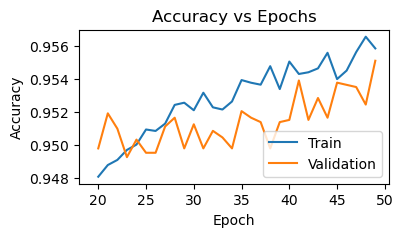

590/590 [==============================] - 1s 969us/step
Model: DL_tune4
Accuracy train: 0.96515
Accuracy test: 0.95433
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8576
           1       0.97      0.95      0.96     10300

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876



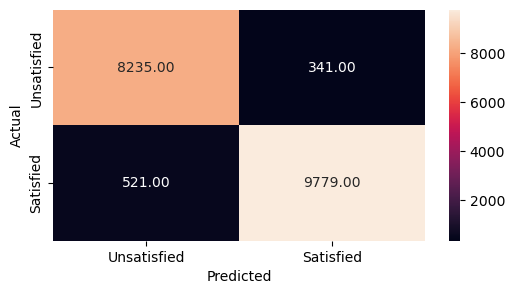

In [98]:
# MODEL DL_tune4
backend.clear_session()
DL_tune4 = Sequential()

# Layer 1 (input layer)
DL_tune4.add(Dense(320,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
DL_tune4.add(Dropout(0.2))
#Layer 2
DL_tune4.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
DL_tune4.add(Dropout(0.5))
#Layer 3
DL_tune4.add(Dense(196,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune4.add(Dropout(0.5))
#Layer 4
DL_tune4.add(Dense(196,activation='relu',kernel_initializer='he_uniform'))
DL_tune4.add(Dropout(0.2))
#Layer 5
DL_tune4.add(Dense(128,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune4.add(Dropout(0.1))
#Layer 6
DL_tune4.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
DL_tune4.add(Dropout(0.5))
#Output layer
DL_tune4.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.001)
DL_tune4.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = DL_tune4.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.1)
accuracy_vs_epochs(history,20)
dl_performance('DL_tune4', DL_tune4)

### 7/ 7 layers

In [89]:
backend.clear_session()

In [90]:
def build_model(h):
    model = keras.Sequential()
    # Number of layer: min - max
    no_of_layers = 7 # h.Int('num_layers', 2, 8)
    neurons_per_layer = [32,32,64,128,196,256,256,256,320,320,320,320]

    for i in range(no_of_layers):
        model.add(layers.Dense(
            units=h.Choice('units_' + str(i), neurons_per_layer[(no_of_layers-i):(no_of_layers-i+3)]),
            # Activation function for each layer
            activation= h.Choice('act_' + str(i), ['relu','sigmoid'])))
        # Tune with dropout or not
        model.add(Dropout(h.Choice('dropout_'+ str(i), [0.0, 0.1,0.2,0.5])))
    # output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    # compiler
    model.compile(
        # Adjust learning rate
        optimizer=keras.optimizers.Adam(h.Choice('learning_rate', [1e-2, 1e-3])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [91]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  #defaul 5-7
    executions_per_trial=3, #defaul 3-5
    project_name='Job',
    overwrite=True)
#tuner.search_space_summary()
start = time.time()
tuner.search(X_train, y_train, epochs=8, # default about 5-10
             validation_data = (X_test,y_test))
print('Tuning completed in: ', round(time.time()-start,2),'s')
tuner.results_summary()

Trial 5 Complete [00h 03m 34s]
val_accuracy: 0.7672529419263204

Best val_accuracy So Far: 0.9391290545463562
Total elapsed time: 00h 17m 21s
INFO:tensorflow:Oracle triggered exit
Tuning completed in:  1041.38 s
Results summary
Results in .\Job
Showing 10 best trials
Trial summary
Hyperparameters:
units_0: 320
act_0: sigmoid
dropout_0: 0.0
units_1: 320
act_1: sigmoid
dropout_1: 0.1
units_2: 256
act_2: relu
dropout_2: 0.5
units_3: 256
act_3: relu
dropout_3: 0.0
units_4: 196
act_4: sigmoid
dropout_4: 0.0
units_5: 128
act_5: relu
dropout_5: 0.2
units_6: 128
act_6: sigmoid
dropout_6: 0.1
learning_rate: 0.001
Score: 0.9391290545463562
Trial summary
Hyperparameters:
units_0: 320
act_0: sigmoid
dropout_0: 0.1
units_1: 320
act_1: relu
dropout_1: 0.1
units_2: 256
act_2: relu
dropout_2: 0.2
units_3: 196
act_3: relu
dropout_3: 0.2
units_4: 196
act_4: relu
dropout_4: 0.0
units_5: 64
act_5: relu
dropout_5: 0.1
units_6: 128
act_6: relu
dropout_6: 0.2
learning_rate: 0.01
Score: 0.9093204736709595
Tri

#### Build model with above parameter

In [95]:
create_DL_fixed_layer('DL_tune5', 7)

 units_0: 320 act_0: sigmoid dropout_0: 0.0 units_1: 320 act_1: sigmoid dropout_1: 0.1 units_2: 256 act_2: relu dropout_2: 0.5 units_3: 256 act_3: relu dropout_3: 0.0 units_4: 196 act_4: sigmoid dropout_4: 0.0 units_5: 128 act_5: relu dropout_5: 0.2 units_6: 128 act_6: sigmoid dropout_6: 0.1


# MODEL DL_tune5
backend.clear_session()
DL_tune5 = Sequential()

# Layer 1 (input layer)
DL_tune5.add(Dense(320,activation='sigmoid',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
DL_tune5.add(Dropout(0.0))
#Layer 2
DL_tune5.add(Dense(320,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune5.add(Dropout(0.1))
#Layer 3
DL_tune5.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
DL_tune5.add(Dropout(0.5))
#Layer 4
DL_tune5.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
DL_tune5.add(Dropout(0.0))
#Layer 5
DL_tune5.add(Dense(196,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune5.add(Dropout(0.0))
#Layer 6
DL_tune5.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
DL_tune5.add(Dropout(0.2))
#Layer 7
DL_tune5.add(Dense(128,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune5.add(Dropout(0.1))
#Output layer
DL_tune5.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.0

Epoch 1/50
1062/1062 [==============================] - 4s 3ms/step - loss: 0.3410 - accuracy: 0.8495 - val_loss: 0.2288 - val_accuracy: 0.8984
Epoch 2/50
1062/1062 [==============================] - 3s 3ms/step - loss: 0.2092 - accuracy: 0.9097 - val_loss: 0.1844 - val_accuracy: 0.9178
Epoch 3/50
1062/1062 [==============================] - 4s 3ms/step - loss: 0.1844 - accuracy: 0.9213 - val_loss: 0.1753 - val_accuracy: 0.9204
Epoch 4/50
1062/1062 [==============================] - 4s 3ms/step - loss: 0.1693 - accuracy: 0.9259 - val_loss: 0.1576 - val_accuracy: 0.9270
Epoch 5/50
1062/1062 [==============================] - 3s 3ms/step - loss: 0.1604 - accuracy: 0.9313 - val_loss: 0.1516 - val_accuracy: 0.9323
Epoch 6/50
1062/1062 [==============================] - 3s 3ms/step - loss: 0.1501 - accuracy: 0.9357 - val_loss: 0.1448 - val_accuracy: 0.9325
Epoch 7/50
1062/1062 [==============================] - 3s 3ms/step - loss: 0.1436 - accuracy: 0.9385 - val_loss: 0.1338 - val_accuracy:

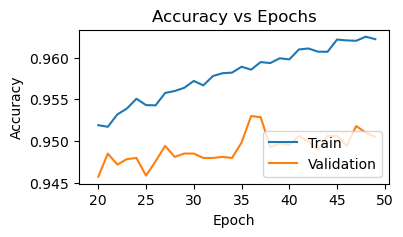

590/590 [==============================] - 1s 1ms/step
Model: DL_tune5
Accuracy train: 0.96425
Accuracy test: 0.9537
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8576
           1       0.97      0.95      0.96     10300

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876



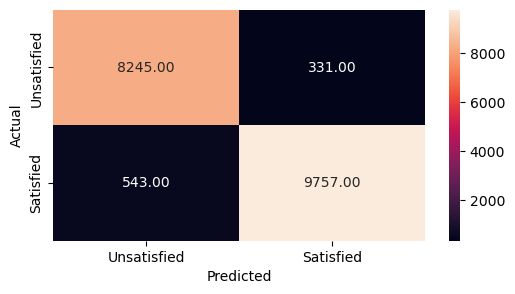

In [99]:
# MODEL DL_tune5
backend.clear_session()
DL_tune5 = Sequential()

# Layer 1 (input layer)
DL_tune5.add(Dense(320,activation='sigmoid',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
DL_tune5.add(Dropout(0.0))
#Layer 2
DL_tune5.add(Dense(320,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune5.add(Dropout(0.1))
#Layer 3
DL_tune5.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
DL_tune5.add(Dropout(0.5))
#Layer 4
DL_tune5.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
DL_tune5.add(Dropout(0.0))
#Layer 5
DL_tune5.add(Dense(196,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune5.add(Dropout(0.0))
#Layer 6
DL_tune5.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
DL_tune5.add(Dropout(0.2))
#Layer 7
DL_tune5.add(Dense(128,activation='sigmoid',kernel_initializer='he_uniform'))
DL_tune5.add(Dropout(0.1))
#Output layer
DL_tune5.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.001)
DL_tune5.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = DL_tune5.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.1)
accuracy_vs_epochs(history,20)
dl_performance('DL_tune5', DL_tune5)

### Result

In [100]:
df_accuracy

,Model name,Model arch.,Train Accuracy,Test_Accuracy,Time
0,DL_tune1,<keras.engine.sequential.Sequential object at ...,0.96556,0.95264,0
1,DL_tune2,<keras.engine.sequential.Sequential object at ...,0.96670,0.95327,0
2,DL_tune3,<keras.engine.sequential.Sequential object at ...,0.97873,0.95364,0
3,DL_tune4,<keras.engine.sequential.Sequential object at ...,0.96515,0.95433,0
4,DL_tune5,<keras.engine.sequential.Sequential object at ...,0.96425,0.95370,0


### Make prediction on the submission set

In [115]:
model_list = [
              (DL_tune1,'DL_tune1'),
              (DL_tune2,'DL_tune2'),
              (DL_tune3,'DL_tune3'),
              (DL_tune4,'DL_tune4'),
              (DL_tune5,'DL_tune5'),
             ]

In [116]:
note_version = '6.1'

for model, model_name in model_list:
    export_submission(model_name, model, note_version)
print('All finish')

Exporting  DL_1 ...
1113/1113 [==============================] - 1s 746us/step
Finish  submission_model_DL_1_fromfile_6.0.csv
Exporting  DL_tune1 ...
1113/1113 [==============================] - 1s 870us/step
Finish  submission_model_DL_tune1_fromfile_6.0.csv
Exporting  DL_tune2 ...
1113/1113 [==============================] - 1s 888us/step
Finish  submission_model_DL_tune2_fromfile_6.0.csv
Exporting  DL_tune2a ...
1113/1113 [==============================] - 1s 1ms/step
Finish  submission_model_DL_tune2a_fromfile_6.0.csv
Exporting  DL_tune2b ...
1113/1113 [==============================] - 1s 1ms/step
Finish  submission_model_DL_tune2b_fromfile_6.0.csv
Exporting  DL_tune2c ...
1113/1113 [==============================] - 1s 1ms/step
Finish  submission_model_DL_tune2c_fromfile_6.0.csv
Exporting  DL_tune2d ...
1113/1113 [==============================] - 1s 851us/step
Finish  submission_model_DL_tune2d_fromfile_6.0.csv
All finish
